In [1]:
import sys, time, argparse, re, gensim, math
import pandas as pd
from tqdm import tqdm
import pickle as pkl
import numpy as np
import faulthandler
import logging
from os.path import exists
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import plotly.graph_objects as go
from  sklearn.preprocessing import normalize
from scipy.spatial import distance
from itertools import combinations

In [2]:
def read_file(input_path):
    logging.info('Opened: ' + input_path)
    with open(input_path, "rb") as f:
        input_obj = pkl.load(f)
        return input_obj

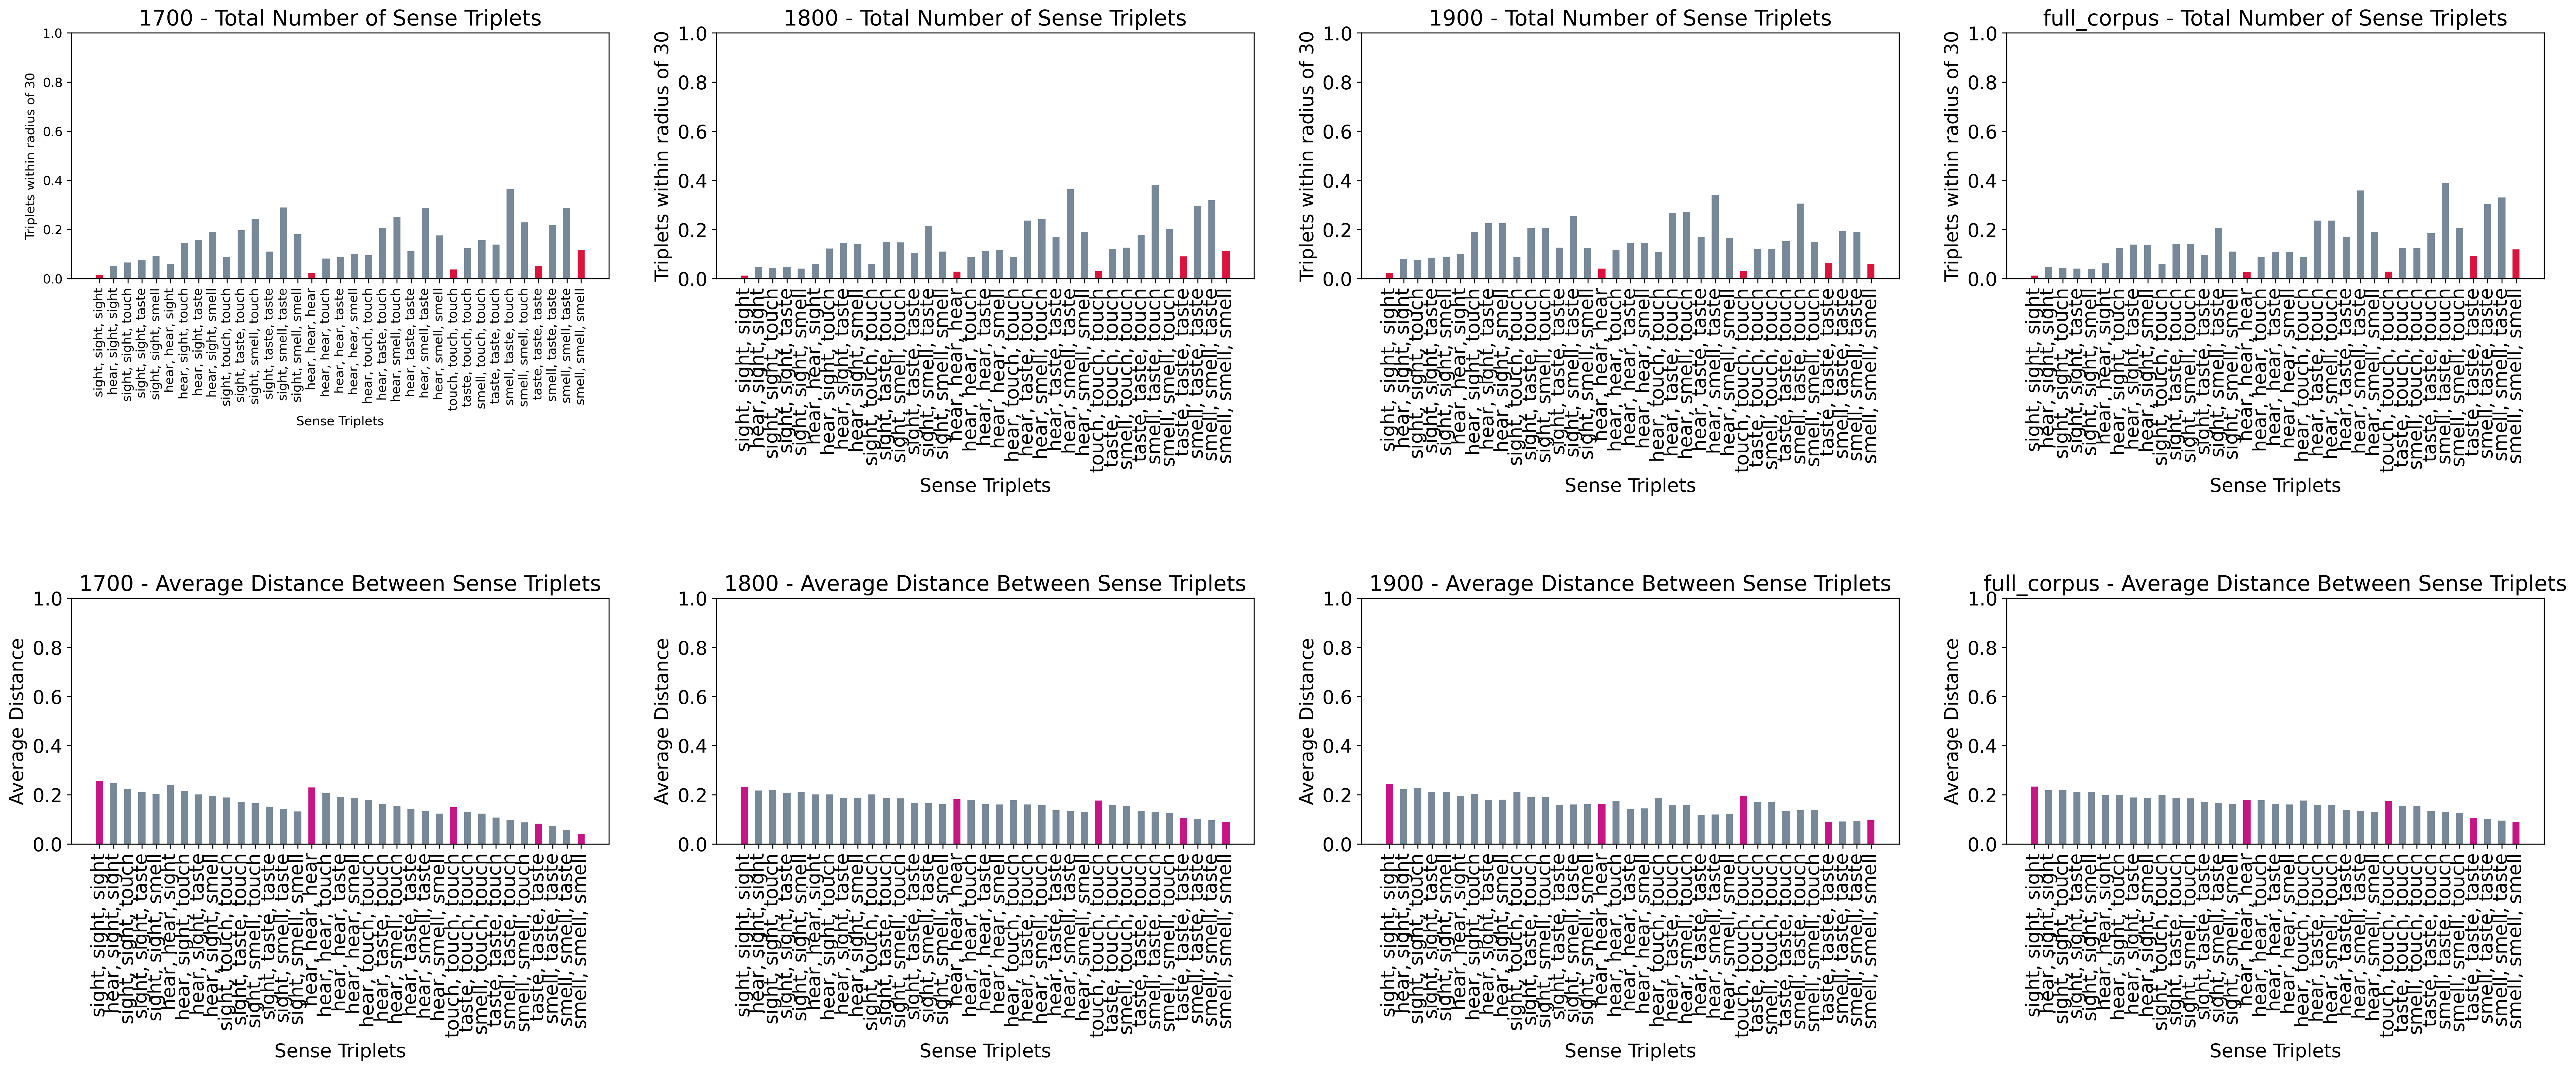

In [3]:
SENSES = ['sight', 'hear', 'touch', 'taste', 'smell']
radius = 30
literary_periods = ['1700', '1800', '1900', 'full_corpus']

plt.figure(figsize=(35,20), dpi = 300)
num_a = 1
num_b = 5
num_c = 9 
plt.tight_layout()


def format_key(triplet):
    return ", ".join(sorted(triplet))

def avg(value):
    ret = 0 if value[1] == 0 else value[0]/value[1]
    return ret
    
for period in literary_periods:
    all_top_descriptors = read_file('../data/' + period + '/' + period + '_all_top_descriptors_500.pickle')
    
    senses_and_freqs = {format_key((SENSES[i],SENSES[j],SENSES[k])):0 for i in range(len(SENSES)) for j in range(i, len(SENSES)) for k in range(j, len(SENSES))}
    senses_and_avgs = {format_key((SENSES[i],SENSES[j],SENSES[k])):[0,0] for i in range(len(SENSES)) for j in range(i, len(SENSES)) for k in range(j, len(SENSES))}
    
    points = []
    points_with_sense = []
    for index, row in all_top_descriptors.iterrows():
        points.append([row['Principal Component 1'], row['Principal Component 2']])
        points_with_sense.append([[row['Principal Component 1'], row['Principal Component 2']], row['modality']])
        
    euclidean_dists = euclidean_distances(points, points)
    
    two_points = []
    visited_points = []
    for i, row in enumerate(euclidean_dists):
        for j, distance in enumerate(row):
            if i == j or sorted((i,j)) in visited_points: continue
#             visited_points.append(sorted((i,j)))
            sense_i = points_with_sense[i][1]
            sense_j = points_with_sense[j][1]
            two_points.append([(i,j), distance, [sense_i, sense_j]])
                
    visited_points = []
    for value in two_points:
        pair, distance, modalities = value
        i = pair[0]
        j = pair[1]
        sense_i = modalities[0]
        sense_j = modalities[1]
        row = euclidean_dists[i]
        for k, distance2 in enumerate(row):
            if i == k or j == k or sorted((i,j, k)) in visited_points: continue
#             visited_points.append(sorted((i,j,k)))
            sense_k = points_with_sense[k][1]
            distance3 = euclidean_dists[j][k]
            triplet = format_key([sense_i, sense_j, sense_k])
            senses_and_avgs[triplet][0] += sum([distance, distance2, distance3])
            senses_and_avgs[triplet][1] += 1
            if distance > radius or distance2 > radius: continue
            senses_and_freqs[triplet] += 1
                
    senses_and_avgs = {pair:avg(value) for pair, value in senses_and_avgs.items()}
    
    colors1 = ['lightslategray',] * len(senses_and_freqs)
    same_indices = [i for i, pair in enumerate(senses_and_freqs) if pair.split(", ")[0] == pair.split(", ")[1] and pair.split(", ")[1] == pair.split(", ")[2]]
    for i in same_indices:
        colors1[i] = "crimson"
    layout = go.Layout(
        title = period + " - Total Number of Sense Triplets",
        xaxis = dict(title="Sense Triplets"),
        yaxis = dict(title="Triplets within radius of " + str(radius))
    )

    fig = go.Figure(layout=layout,
                    data=[go.Bar(x = list(senses_and_freqs.keys()),
                            y = normalize([list(senses_and_freqs.values())])[0],
                    marker_color=colors1)])

    fig.update_yaxes(range=[0, 1])
    fig.show()
    fig.write_html('../visuals/' + period + '/' + period + '_total_sense_triplets_500.html')

    layout = go.Layout(
            title = period + " - Average Distance Between Sense Triplets",
            xaxis = dict(title="Sense Triplets"),
            yaxis = dict(title="Average Distance")
        )
    colors2 = ['lightslategray',] * len(senses_and_avgs)
    same_indices = [i for i, pair in enumerate(senses_and_avgs) if pair.split(", ")[0] == pair.split(", ")[1] and pair.split(", ")[1] == pair.split(", ")[2]]
    for i in same_indices:
        colors2[i] = "mediumvioletred"
    fig = go.Figure(layout=layout,
                    data=[go.Bar(x = list(senses_and_avgs.keys()),
                            y = normalize([list(senses_and_avgs.values())])[0],
                    marker_color=colors2)])
    fig.update_yaxes(range=[0, 1])
    fig.show()
    fig.write_html('../visuals/' + period + '/' + period + '_average_distance_between_sense_triplets_500.html')
    
    plt.subplot(3, 4, num_a)
    num_a += 1
    plt.bar(list(senses_and_freqs.keys()), normalize([list(senses_and_freqs.values())])[0], label=list(senses_and_freqs.keys()), width=0.5, color = colors1)
    plt.title(period + " - Total Number of Sense Triplets", fontsize=17)
    plt.xlabel('Sense Triplets')
    plt.ylabel("Triplets within radius of " + str(radius))
    plt.rc('axes', labelsize=15)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xticks(rotation = 90)
    plt.ylim(0, 1)

    
    plt.subplot(3, 4, num_b)
    num_b += 1
    plt.bar(list(senses_and_avgs.keys()), normalize([list(senses_and_avgs.values())])[0], label=list(senses_and_avgs.keys()), width=0.5, color = colors2)
    plt.title(period + " - Average Distance Between Sense Triplets", fontsize=17)
    plt.xlabel('Sense Triplets')
    plt.ylabel("Average Distance")
    plt.rc('axes', labelsize=15)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xticks(rotation = 90) 
    plt.ylim(0, 1)

    
plt.subplots_adjust(hspace=1.3)
plt.savefig('../visuals/all_sense_triplets.jpeg', bbox_inches="tight", dpi=300, transparent=False,)    
plt.show()